In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import statsmodels.api as sm
from sklearn import linear_model
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_squared_error
from statsmodels.regression.quantile_regression import QuantReg

In [59]:
import os

In [79]:
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('data/train/train.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [161]:
train.describe()

,Day,Time,GHI,DHI,DNI,WS,RH,T,TARGET
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,547.000000,11.750000,299.136492,64.344121,234.792371,2.456033,56.793102,9.279928,17.790630
std,316.102148,6.926765,392.456413,103.897125,349.684583,1.426874,22.052875,10.179741,25.759955
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.590000,-19.000000,0.000000
25%,273.000000,5.875000,0.000000,0.000000,0.000000,1.400000,39.697500,1.000000,0.000000
50%,547.000000,11.750000,0.000000,0.000000,0.000000,2.200000,57.600000,9.000000,0.000000
75%,821.000000,17.625000,655.000000,87.000000,469.000000,3.200000,72.770000,17.000000,32.089890
max,1094.000000,23.500000,1153.000000,528.000000,1059.000000,12.000000,100.000000,35.000000,99.913939


### Handle columns

In [11]:
train['GHI'] = train['DHI'] + train['DNI'] # ghi = dhi + dni 

In [111]:
train.insert(3,'Time',train['Hour']+ (train['Minute'] == 30) *0.5 )

In [ ]:
del train['Hour'] 

In [119]:
del train['Minute'] 

### FEATURE : DAY ,T

In [169]:
T_day = train['T'].rolling(window=48).mean()[47::48]       
#T of days # 30분마다 나눠있어서 하루 48개

In [186]:
T_day.index = list(range(len(T_day)))

In [187]:
T_day

0      -7.979167
1      -6.312500
2      -6.479167
3      -5.687500
4       0.854167
          ...   
1090   -0.895833
1091    0.854167
1092    2.187500
1093    1.687500
1094   -2.708333
Name: T, Length: 1095, dtype: float64

In [193]:
T_month = []
for y in range(3) :
    year = 365
    T_month.append( T_day[year*y:year*(y+1)] )
    T_month[y] = T_month[y].rolling(30).mean()[29::30]
    T_month[y].index = list(range(1,len(T_month[y] ) + 1  )   )

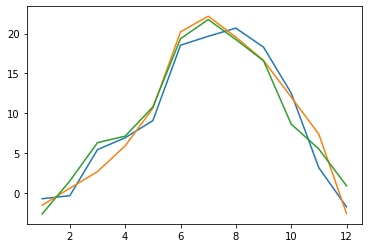

In [205]:
for x in range(3):
    T_month[x].plot()

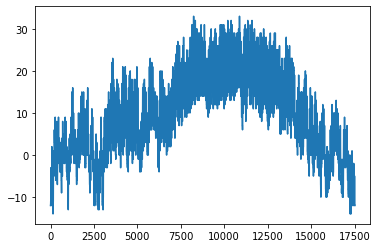

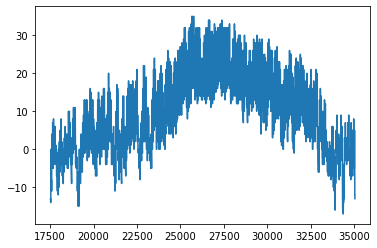

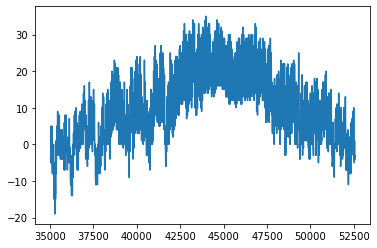

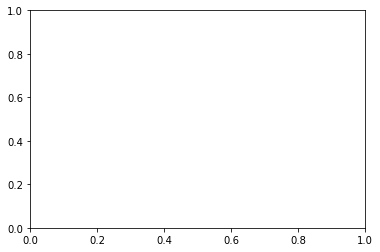

In [160]:
for x in range(3):
    year =365*48
    
    plt.plot(train['T'][year*x:year*(x+1)])
    plt.show()
    plt.cla()

In [7]:
len(train) # 365 x 3 x 48

52560

In [76]:
def single_observation(col,start=0,end=365): # per day
    dir_name ='eda_var_target'
    if end > 1095 :
        print("(╬▔皿▔)╯ enter num under 1095")
        return 1
    size = 48
    plt.xlabel(col)
    plt.ylabel('Target')
    for x in range(start,end):
        plt.scatter(train[size*x:(size)*(x+1)][col],train[size*x:(size)*(x+1)]['TARGET'])
        
#         plt.show()
    if not os.path.exists(dir_name) :
        os.makedirs(dir_name)
    plt.savefig('%s/%s-target_%s-%sday.png'%(dir_name,col,start,end))
    plt.cla() #cleaer axes 
def single_distribution(col,start=0,end=365): # per day
    dir_name ='eda_var_distribution'
    if end > 1095 :
        print("(╬▔皿▔)╯ enter num under 1095")
        return 1
    size = 48
    plt.xlabel(col)
    plt.ylabel('count')
    for x in range(start,end):
        plt.hist(train[size*x:(size)*(x+1)][col])
        
#         plt.show()
    if not os.path.exists(dir_name) :
        os.makedirs(dir_name)
    plt.savefig('%s/%s-histogram_%s-%sday.png'%(dir_name,col,start,end))
    plt.cla() #cleaer axes     
# single_observation('T',730,1095) #max : 365x3
def allyears(col):
    year = 365
    for x in range(3):
#         single_observation(col,year*x,year*(x+1))
        single_distribution(col,year*x,year*(x+1))
    

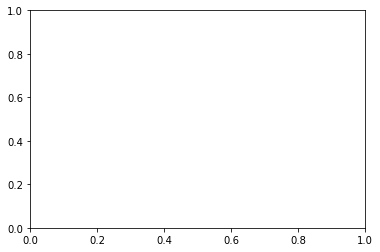

In [77]:
for col in train.columns :
    if col == "TARGET" :
        continue
    allyears(col)

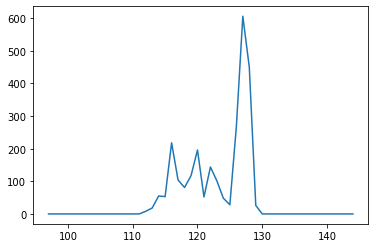

In [22]:
plt.plot(train[97:145]['GHI'])

In [ ]:
fig, ax = plt.subplots()
ax.plot(
    train[:49]['GHI'], train['TARGET'], label='y=x',
    marker='o',
    color='blue',
    linestyle='-.'
)
ax.plot(
    x, x**2, label='y=x^2',
    marker='^',
    color='red',
    linestyle='--'
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(
    loc='upper left',
    shadow=True,
    fancybox=True,
    borderpad=2
)

In [14]:
train[:48]

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI
0,0,0,0,0,0,1.5,69.08,-12,0.000000,0
1,0,0,30,0,0,1.5,69.06,-12,0.000000,0
2,0,1,0,0,0,1.6,71.78,-12,0.000000,0
3,0,1,30,0,0,1.6,71.75,-12,0.000000,0
4,0,2,0,0,0,1.6,75.20,-12,0.000000,0
5,0,2,30,0,0,1.5,69.29,-11,0.000000,0
6,0,3,0,0,0,1.5,72.56,-11,0.000000,0
7,0,3,30,0,0,1.4,72.55,-11,0.000000,0
8,0,4,0,0,0,1.3,74.62,-11,0.000000,0
9,0,4,30,0,0,1.3,74.61,-11,0.000000,0


# 전처리


가장 가까운 정보(2일 전 데이터)로 미래를 예측

In [4]:
for i in range(0,81):
    s1 = "test_%d = pd.read_csv('data/test/%d.csv')"%(i,i)
    exec(s1)

In [5]:
for i in range(0, 1093):
    s1 = "train_%d = pd.concat([train.loc[train['Day'] == %d].reset_index(drop = True), train.loc[train['Day'] == %d + 2].reset_index(drop = True).rename(columns = {'TARGET' : 'TARGET_2'})['TARGET_2']], axis = 1)"%(i, i, i)
    exec(s1)

In [6]:
train_x = pd.concat([train_0, train_1], axis = 0).reset_index(drop=True)
train_x

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,TARGET_2
0,0,0,0,0,0,1.5,69.08,-12,0.0,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
91,1,21,30,0,0,2.2,74.50,-8,0.0,0.0
92,1,22,0,0,0,2.2,72.83,-8,0.0,0.0
93,1,22,30,0,0,2.2,72.82,-8,0.0,0.0
94,1,23,0,0,0,2.2,72.51,-8,0.0,0.0


In [26]:
for i in range(len(train_x['T']) ):
    if i == len(train_x['T'])-1:
        break
    if train_x['T'][i] == train_x['T'][i+1] :
        print(train_x['T'][i])



-12
-12
-12
-12
-11
-11
-11
-11
-11
-11
-12
-12
-3
-3
-3
-3
-3
-4
-4
-4
-5
-6
-7
-8
-8
-8
-8
-8
-9
-9
-9
-10
-10
-10
-11
-11
-11
-12
-12
-12
-12
-12
-12
-12
-12
0
0
1
1
0
-6
-7
-8
-8
-8
-8
-8
-8
-8


In [30]:
for i in range(2, 1093):
    s1 = "train_x = pd.concat([train_x, train_%d], axis = 0).reset_index(drop = True)"%(i)
    exec(s1)

In [31]:
#변수생성
hour_mean = train_x.groupby(['Hour'])['TARGET'].mean()
minute_mean = train_x.groupby(['Minute'])['TARGET'].mean()
train_x['Hour_mean'] = train_x['Hour'].map(hour_mean)
train_x['Minute_mean'] = train_x['Minute'].map(minute_mean)

In [32]:
train_x = train_x.drop(['Day', 'Hour', 'Minute'], axis = 1)
train_x

,DHI,DNI,WS,RH,T,TARGET,TARGET_2,Hour_mean,Minute_mean
0,0,0,1.5,69.08,-12,0.0,0.0,0.0,17.810955
1,0,0,1.5,69.06,-12,0.0,0.0,0.0,17.799137
2,0,0,1.6,71.78,-12,0.0,0.0,0.0,17.810955
3,0,0,1.6,71.75,-12,0.0,0.0,0.0,17.799137
4,0,0,1.6,75.20,-12,0.0,0.0,0.0,17.810955
...,...,...,...,...,...,...,...,...,...
52459,0,0,3.5,55.97,-1,0.0,0.0,0.0,17.799137
52460,0,0,3.9,54.23,-2,0.0,0.0,0.0,17.810955
52461,0,0,4.1,54.21,-2,0.0,0.0,0.0,17.799137
52462,0,0,4.3,56.46,-2,0.0,0.0,0.0,17.810955


y : TARGET_2(2일 후 발전량)

In [33]:
x_train = train_x.drop(['TARGET_2'], axis = 1)
y_train = train_x['TARGET_2']

In [34]:
for i in range(0, 81):
    s1 = "test_%d = test_%d[240:].reset_index(drop = True)"%(i,i)
    s2 = "hour_mean = test_%d.groupby(['Hour'])['TARGET'].mean()"%(i)
    s3 = "minute_mean = test_%d.groupby(['Minute'])['TARGET'].mean()"%(i)
    s4 = "test_%d['Hour_mean'] = test_%d['Hour'].map(hour_mean)"%(i,i)
    s5 = "test_%d['Minute_mean'] = test_%d['Minute'].map(minute_mean)"%(i,i)
    s6 = "test_%d = test_%d.drop(['Day', 'Hour', 'Minute'], axis = 1)"%(i,i)
    exec(s1)
    exec(s2)
    exec(s3)
    exec(s4)
    exec(s5)
    exec(s6)

In [35]:
test_x = pd.concat([test_0, test_1], axis = 0).reset_index(drop=True)
test_x

,DHI,DNI,WS,RH,T,TARGET,Hour_mean,Minute_mean
0,0,0,2.1,52.83,-4.4,0.0,0.0,6.061008
1,0,0,2.0,54.44,-4.8,0.0,0.0,5.926100
2,0,0,1.9,52.78,-5.1,0.0,0.0,6.061008
3,0,0,1.8,53.59,-5.3,0.0,0.0,5.926100
4,0,0,1.7,52.63,-5.5,0.0,0.0,6.061008
...,...,...,...,...,...,...,...,...
187,0,0,1.7,43.65,-5.2,0.0,0.0,11.308777
188,0,0,1.5,40.62,-4.9,0.0,0.0,11.297040
189,0,0,1.5,40.62,-4.9,0.0,0.0,11.308777
190,0,0,1.5,39.21,-4.9,0.0,0.0,11.297040


In [36]:
for i in range(2, 81):
    s1 = "test_x = pd.concat([test_x, test_%d], axis = 0).reset_index(drop = True)"%(i)
    exec(s1)

In [37]:
x_test = test_x.copy()

# 변수선택(best subest)

In [38]:
def linear_reg(X,y):
    model = linear_model.LinearRegression(fit_intercept = True)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared

#X변수 개수
m = len(y_train)
k = 8
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#1 ~ 8까지 모든 조합에 대한 성능 테스트(RSS, R_Squared)
for k in tnrange(1,len(x_train.columns) + 1):
    for combo in itertools.combinations(x_train.columns,k):
        tmp_result = linear_reg(x_train[list(combo)],y_train)  
        RSS_list.append(tmp_result[0])              
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#결과
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

<ipython-input-38-d0afe2482ad3>:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(x_train.columns) + 1):


In [39]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,1.762009e+07,0.494386,"(DHI,)",1.058685e+07,0.696207
1,1,2.235501e+07,0.358516,"(DNI,)",1.058685e+07,0.696207
2,1,3.281036e+07,0.058496,"(WS,)",1.058685e+07,0.696207
3,1,2.265496e+07,0.349909,"(RH,)",1.058685e+07,0.696207
4,1,2.578791e+07,0.260008,"(T,)",1.058685e+07,0.696207


In [40]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
display(df_min.head(5))

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
6,1,1.058685e+07,0.696207,"(Hour_mean,)",1.058685e+07,0.696207
33,2,8.892195e+06,0.744836,"(TARGET, Hour_mean)",8.892195e+06,0.744836
69,3,8.319371e+06,0.761273,"(DNI, TARGET, Hour_mean)",8.319371e+06,0.761273
143,4,8.105550e+06,0.767409,"(DNI, T, TARGET, Hour_mean)",8.105550e+06,0.767409
178,5,8.092551e+06,0.767782,"(DHI, DNI, T, TARGET, Hour_mean)",8.092551e+06,0.767782


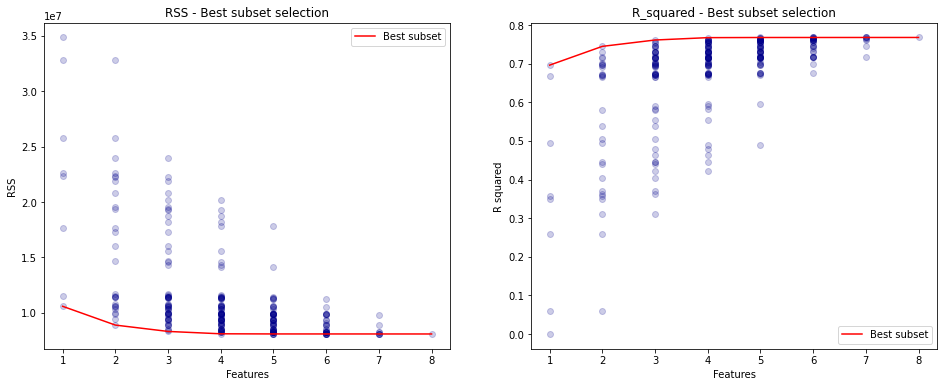

In [41]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.set_xlabel('Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

# 예측

In [42]:
sub['q_0.1'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.1).predict(x_test['Hour_mean'])
sub['q_0.2'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.2).predict(x_test['Hour_mean'])
sub['q_0.3'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.3).predict(x_test['Hour_mean'])
sub['q_0.4'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.4).predict(x_test['Hour_mean'])
sub['q_0.5'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.5).predict(x_test['Hour_mean'])
sub['q_0.6'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.6).predict(x_test['Hour_mean'])
sub['q_0.7'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.7).predict(x_test['Hour_mean'])
sub['q_0.8'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.8).predict(x_test['Hour_mean'])
sub['q_0.9'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.9).predict(x_test['Hour_mean'])

In [44]:
sub.to_csv('1214_third.csv', index = False)